In [1]:
# Import des modules

#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
import numpy as np
from sklearn.metrics import make_scorer,mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

#RF
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree

#Dataset
import pandas as pd
# Option d'affichage pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

#Graphique
import matplotlib.pyplot as plt

# Sauvegarde modele
import bentoml

In [2]:
# Chargement du dataset contenant les features
building_consumption = pd.read_csv("building_features.csv")
building_cons=building_consumption.copy()

In [3]:
# Séparation dataframe feature/variable cible
X = building_cons.drop(columns=['SiteEnergyUseWN(kBtu)'])
y = building_cons['SiteEnergyUseWN(kBtu)']
X.head()

,PrimaryPropertyType,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFABuilding(s),UsesSteam,UsesElectricity,UsesNaturalGas,BuildingAge
0,Hotel,DOWNTOWN,1.00,12,88434,1,1,1,98
1,Hotel,DOWNTOWN,1.00,11,88502,0,1,1,29
2,Hotel,DOWNTOWN,1.00,10,61320,1,1,1,99
3,Hotel,DOWNTOWN,1.00,18,113580,0,1,1,45
4,Other,DOWNTOWN,1.00,2,60090,0,1,1,26


In [4]:
# Encodage et scaling sur les colonnes suivantes:

# Colonnes à encoder
cat_cols = ["PrimaryPropertyType", "Neighborhood"]

# Colonnes à scaler
num_cols = ["PropertyGFABuilding(s)", "BuildingAge"]

# Définition de notre preprocess utilisé pour tout les modèles
# ColumnTransformer renvoie une matrice combinée après application de l'encodage
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(sparse_output=False, handle_unknown="ignore"), cat_cols),# Applique le OneHotEncoder sur cat_cols
        ("num", StandardScaler(), num_cols) # Applique le StandardScaler sur num_cols
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

In [5]:
# Séparation des données en train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=808
)

In [6]:
# Création du pipeline avec DummyRegressor
model = Pipeline([
    ("preprocess", preprocess),
    ("dum", DummyRegressor())
])

In [7]:
# Entraînement du model de DummyRegressor
model.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('dum', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [8]:
# Prédictions Dummy Regressor en utilisant un train_test_split classique
y_pred = model.predict(X_test)

# Metriques
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('RMSE:',rmse)
print('MAE:',mae)
print('R²:',r2)

RMSE: 3392528.272587108
MAE: 2618238.2973641003
R²: -0.00016856231166761937


In [9]:
# Définition de la fonction de modélisation utilisant cross_validate, avec scaling de y
def modelisation(mod, preprocessing, X, y, X_train, X_test, y_train, y_test):
    # Création du pipeline avec model choisi, en appliquant un StandardScaler sur la variable cible
    model = Pipeline([
    ("preprocess", preprocessing),
    ("reg", TransformedTargetRegressor(
        regressor=mod,
        transformer=StandardScaler()
    ))
    ])
    
    # Entraînement du model de choisi
    model.fit(X_train, y_train)
    
    # Définition des variables de scores pour le cross_validate
    scoring = {
        'RMSE': make_scorer(mean_squared_error),
        'MAE': make_scorer(mean_absolute_error),
        'R2': 'r2'  # R² peut être passé directement comme string
    }
    
    # Appliquer la cross-validation
    cv_results = cross_validate(model, X, y, cv=5, scoring=scoring, return_train_score=False)
    
    # Afficher les résultats
    print("RMSE moyen :", np.mean(np.sqrt(cv_results['test_RMSE'])))
    print("MAE moyen  :", np.mean(cv_results['test_MAE']))
    print("R² moyen   :", np.mean(cv_results['test_R2']))

    return model

In [10]:
# Modélisation Dummy
modelisation(DummyRegressor(),preprocess, X, y, X_train, X_test, y_train, y_test)

RMSE moyen : 3360022.948835445
MAE moyen  : 2682300.78043665
R² moyen   : -0.3410006550740899


,steps,"[('preprocess', ...), ('reg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


In [11]:
# Modélisation Régression
modelReg=modelisation(LinearRegression(), preprocess, X, y, X_train, X_test, y_train, y_test)

RMSE moyen : 2092501.8415469578
MAE moyen  : 1495880.774504574
R² moyen   : 0.4813977034240315


In [12]:
# Modélisation SVR
modelSVR=modelisation(SVR(), preprocess, X, y, X_train, X_test, y_train, y_test)

RMSE moyen : 2116016.287640462
MAE moyen  : 1421371.135056868
R² moyen   : 0.47321148262007073


In [13]:
# Modélisation RandomForest
modelForest=modelisation(RandomForestRegressor(), preprocess, X, y, X_train, X_test, y_train, y_test)

RMSE moyen : 2100455.191309537
MAE moyen  : 1446828.360500624
R² moyen   : 0.4780996440670638


In [14]:
# GridSearchCV sur SVR

#Définition des Hyperparametres à tester (160 combinaisons)
param_grid_svr = {
    'reg__regressor__C': [0.1, 1, 10, 50, 100],        
    'reg__regressor__epsilon': [0.01, 0.05, 0.1, 0.2],
    'reg__regressor__gamma': ['scale', 'auto'],       
    'reg__regressor__kernel': ['rbf', 'poly']         
}

grid_svr = GridSearchCV(
    estimator=modelSVR,
    param_grid=param_grid_svr,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

grid_svr.fit(X, y)

print(grid_svr.best_params_)
print(grid_svr.best_score_)

{'reg__regressor__C': 10, 'reg__regressor__epsilon': 0.2, 'reg__regressor__gamma': 'auto', 'reg__regressor__kernel': 'rbf'}
-2015850.451897132


In [15]:
# Test du model SVR optimisé sur les données réelles
svr_best = grid_svr.best_estimator_
y_pred_svr = svr_best.predict(X_test)

rmse_svr_test = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr_test = r2_score(y_test, y_pred_svr)
print("RMSE :", rmse_svr_test)
print("R² :", r2_svr_test)

RMSE : 1970005.7253329442
R² : 0.6627428040442247


In [16]:
# GridSearchCV sur RandomForest

#Définition des Hyperparametres à tester (216 combinaisons)
param_grid_rf = {
    'reg__regressor__n_estimators': [200, 500, 800],   # 3
    'reg__regressor__max_depth': [None, 10, 20, 30],   # 4
    'reg__regressor__min_samples_split': [2, 5, 10],  # 3
    'reg__regressor__min_samples_leaf': [1, 2, 5],    # 3
    'reg__regressor__max_features': ['sqrt', 0.5]     # 2
}

# Définition du GridSearch
grid_forest = GridSearchCV(
    estimator=modelForest,
    param_grid=param_grid_rf,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

# Entraînement du GridSearch
grid_forest.fit(X, y)

print(grid_forest.best_params_)
print(grid_forest.best_score_)

{'reg__regressor__max_depth': 30, 'reg__regressor__max_features': 0.5, 'reg__regressor__min_samples_leaf': 1, 'reg__regressor__min_samples_split': 10, 'reg__regressor__n_estimators': 200}
-2037965.194272987


In [17]:
# Test du model RandomForest optimisé sur les données réelles
rf_best = grid_forest.best_estimator_
y_pred_rf = rf_best.predict(X_test)

# Calcul et affichage des métriques
rmse_rf_test = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf_test = r2_score(y_test, y_pred_rf)
print(rmse_rf_test)
print(r2_rf_test)

1381249.3971754226
0.8342053733247671


In [18]:
# Calcul du permutation importance ( poids de chaque feature) sur le model RandomForest

result = permutation_importance(
    rf_best,
    X_test,
    y_test,
    n_repeats=10,
    random_state=808,
    scoring='neg_root_mean_squared_error'
)

# Création d'un DataFrame à l'aide du 
importances = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
})

importances.sort_values(by='importance_mean', ascending=True, inplace=True)

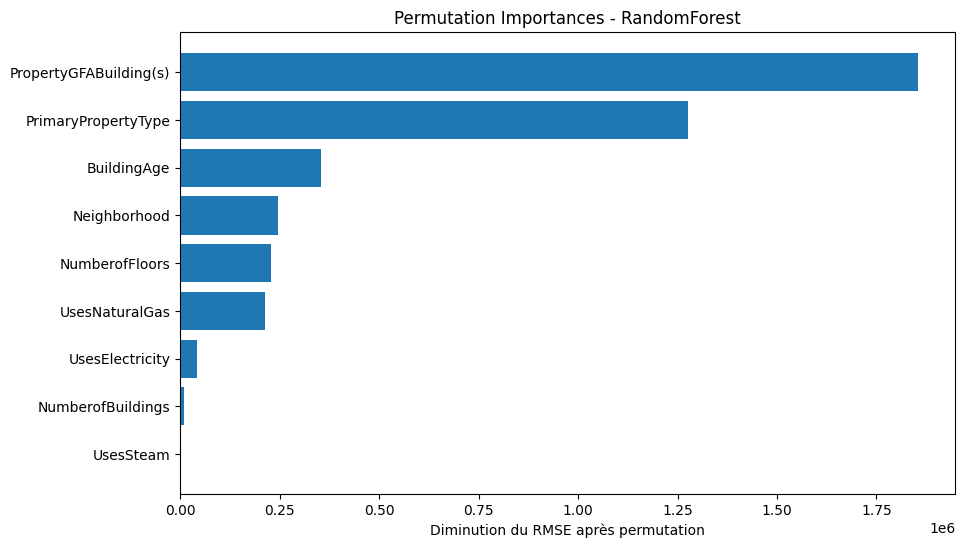

In [19]:
# Graphique 
plt.figure(figsize=(10,6))
plt.barh(importances['feature'], importances['importance_mean'])
plt.xlabel("Diminution du RMSE après permutation")
plt.title("Permutation Importances - RandomForest")
plt.show()

In [20]:
# Preprocess alternatif des données sans Pipeline:

# Features
X_train_trans = preprocess.fit_transform(X_train)
X_test_trans  = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()

# Cible
y_scaler = StandardScaler()

y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled  = y_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

In [21]:
# Entraînement du RF sans pipeline

rf = RandomForestRegressor(
    n_estimators=800,
    random_state=808,
    max_depth=30,
    max_features=0.5,
    min_samples_leaf=1,
    min_samples_split=10
)

rf.fit(X_train_trans, y_train_scaled)

,n_estimators,800
,criterion,'squared_error'
,max_depth,30
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


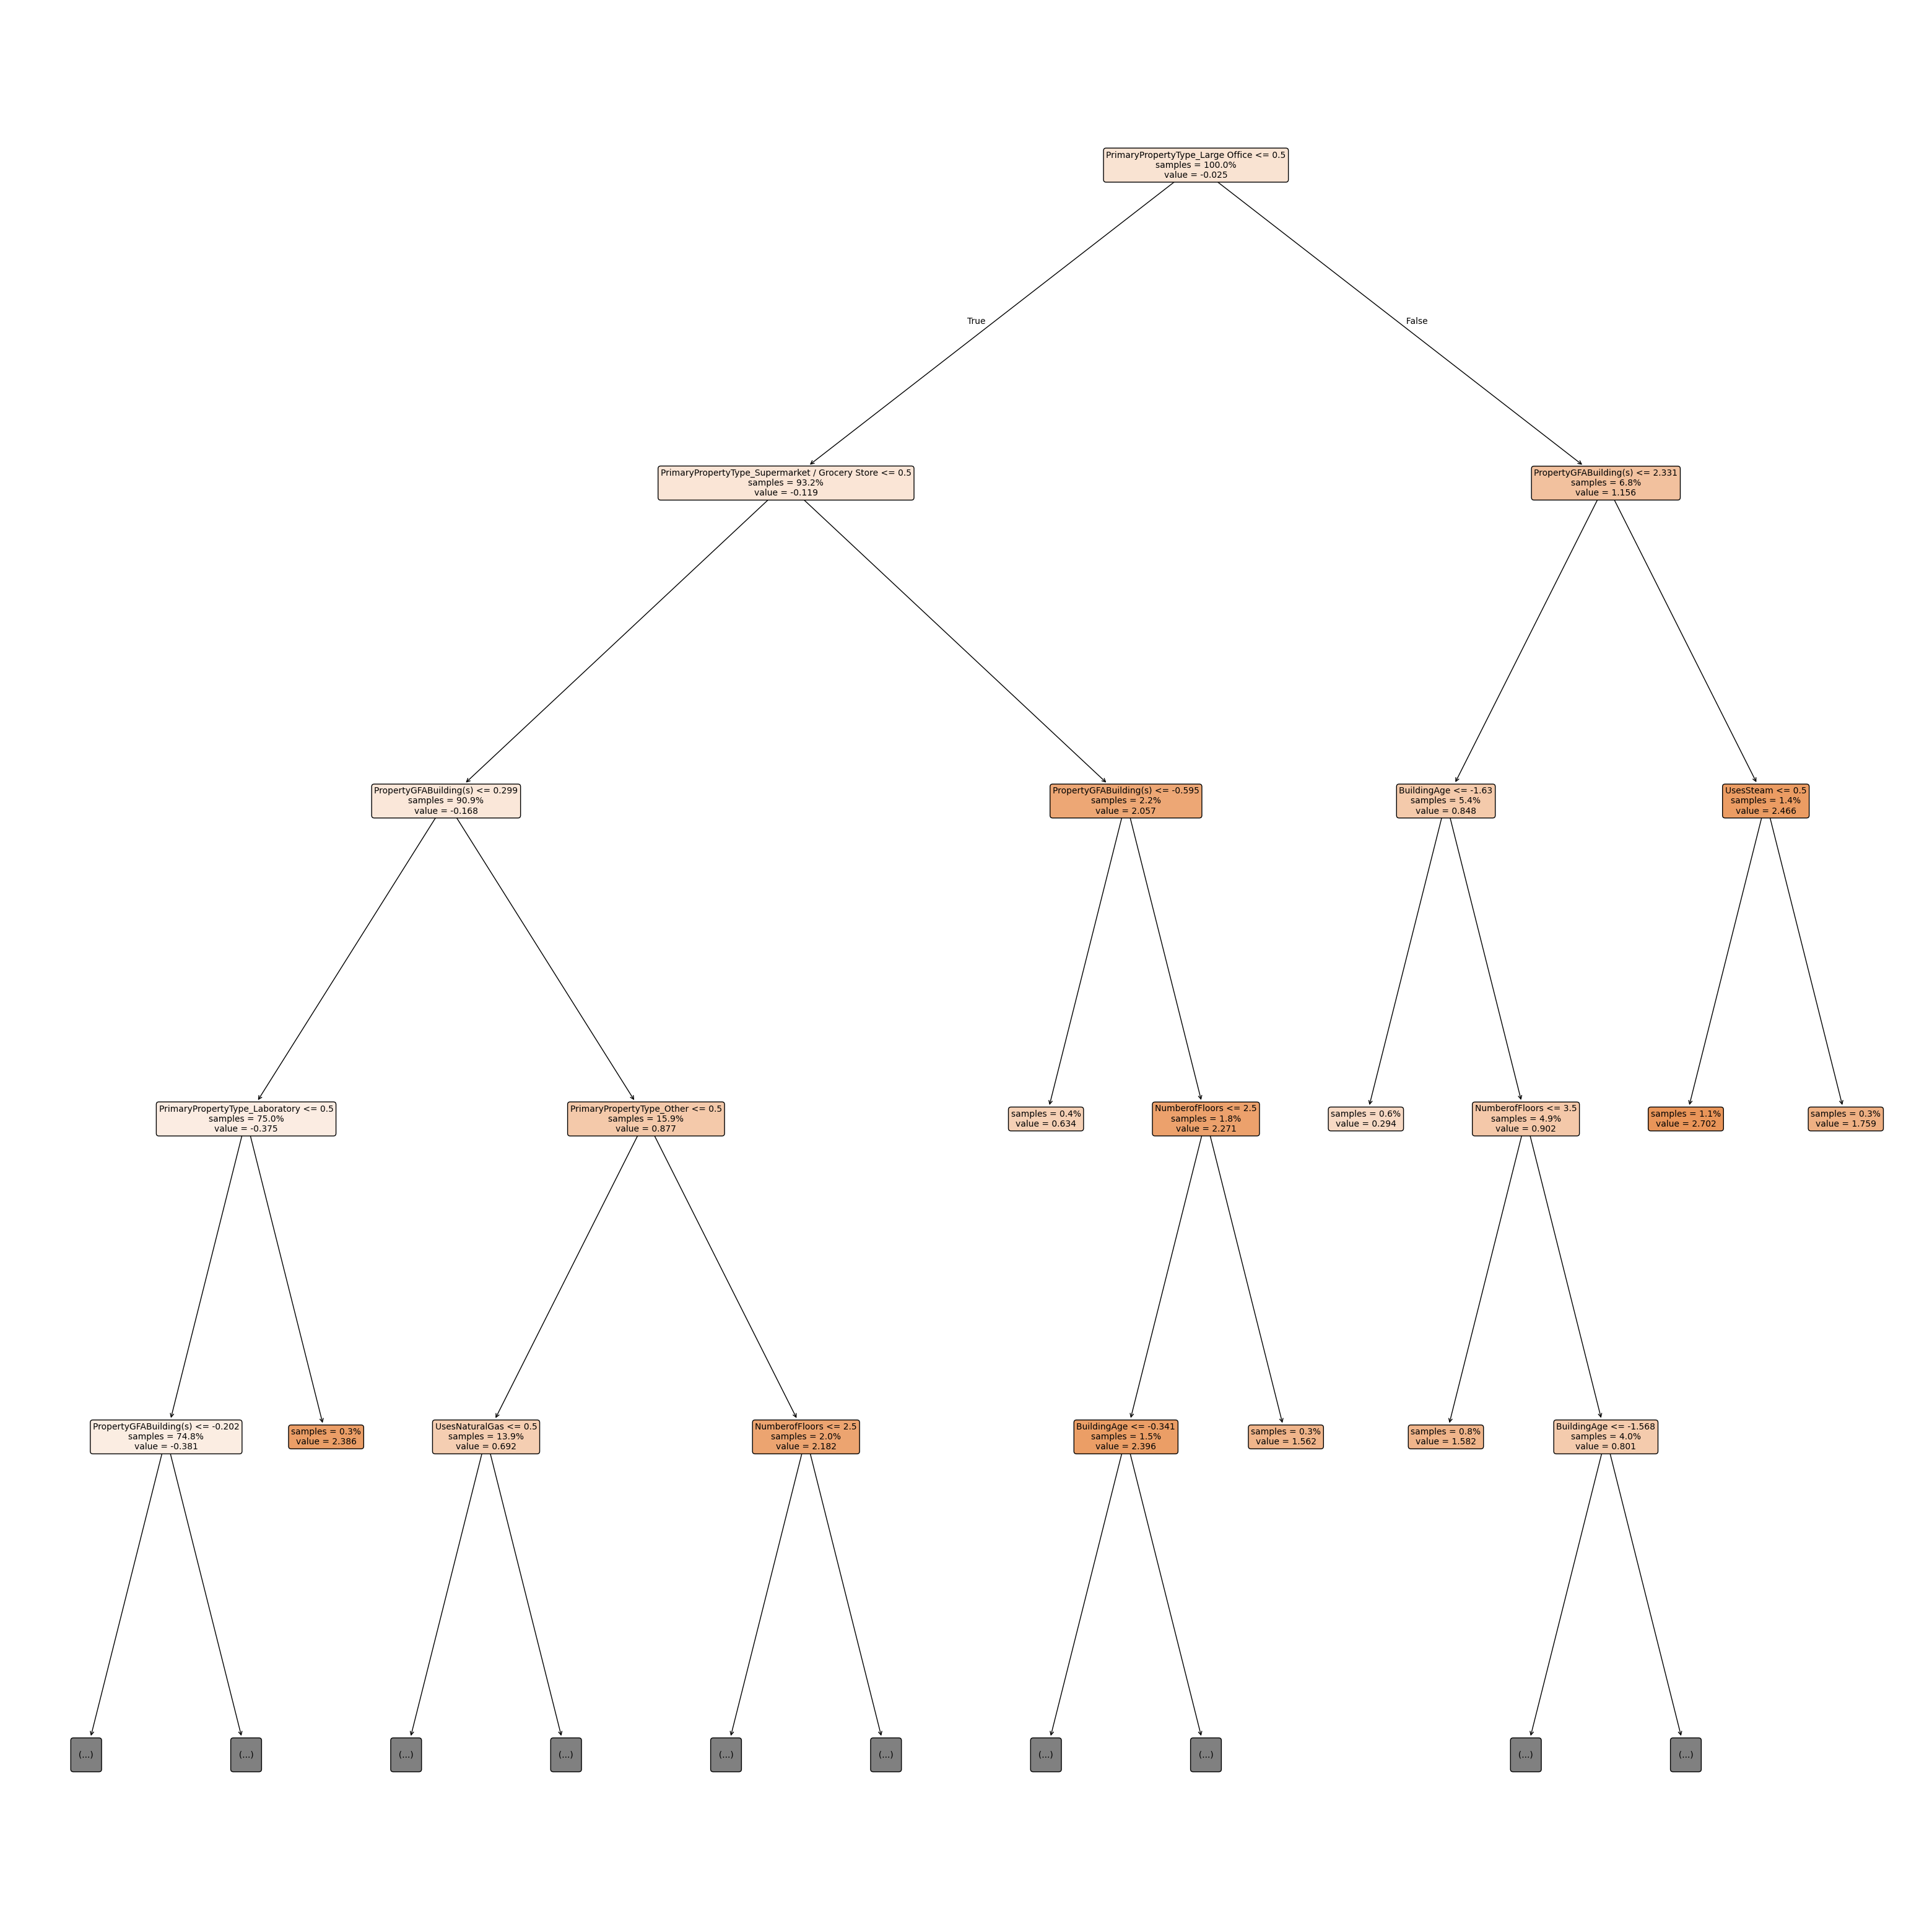

In [22]:
# Tree_plot du model RF

tree = rf.estimators_[0] 

plt.figure(figsize=(40,40))
plot_tree(
    tree,
    feature_names=feature_names,
    filled=True,
    max_depth=4,
    impurity=False,     # enlève la variance
    proportion=True,   # valeurs normalisées
    rounded=True,
    fontsize=10
)
plt.show()

In [23]:
# Feature_importance du RF
importancesBis = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=True)

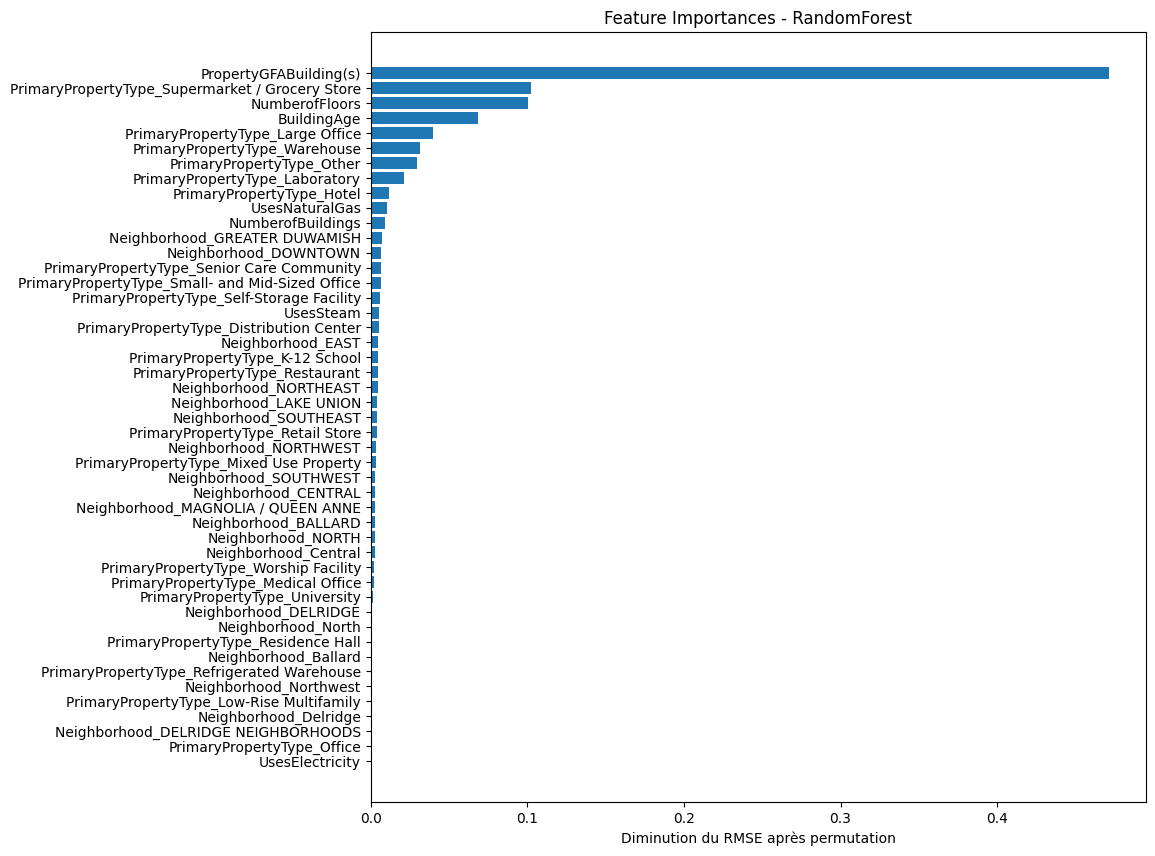

In [24]:
# Graphique feature_importance
plt.figure(figsize=(10,10))
plt.barh(importancesBis['feature'], importancesBis['importance'])
plt.xlabel("Diminution du RMSE après permutation")
plt.title("Feature Importances - RandomForest")
plt.show()

In [25]:
# Permutation importance du RF alternatif
result = permutation_importance(
    rf,
    X_test_trans,
    y_test_scaled,
    n_repeats=10,
    random_state=808,
    scoring='neg_root_mean_squared_error'
)

perm_importances = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=True)

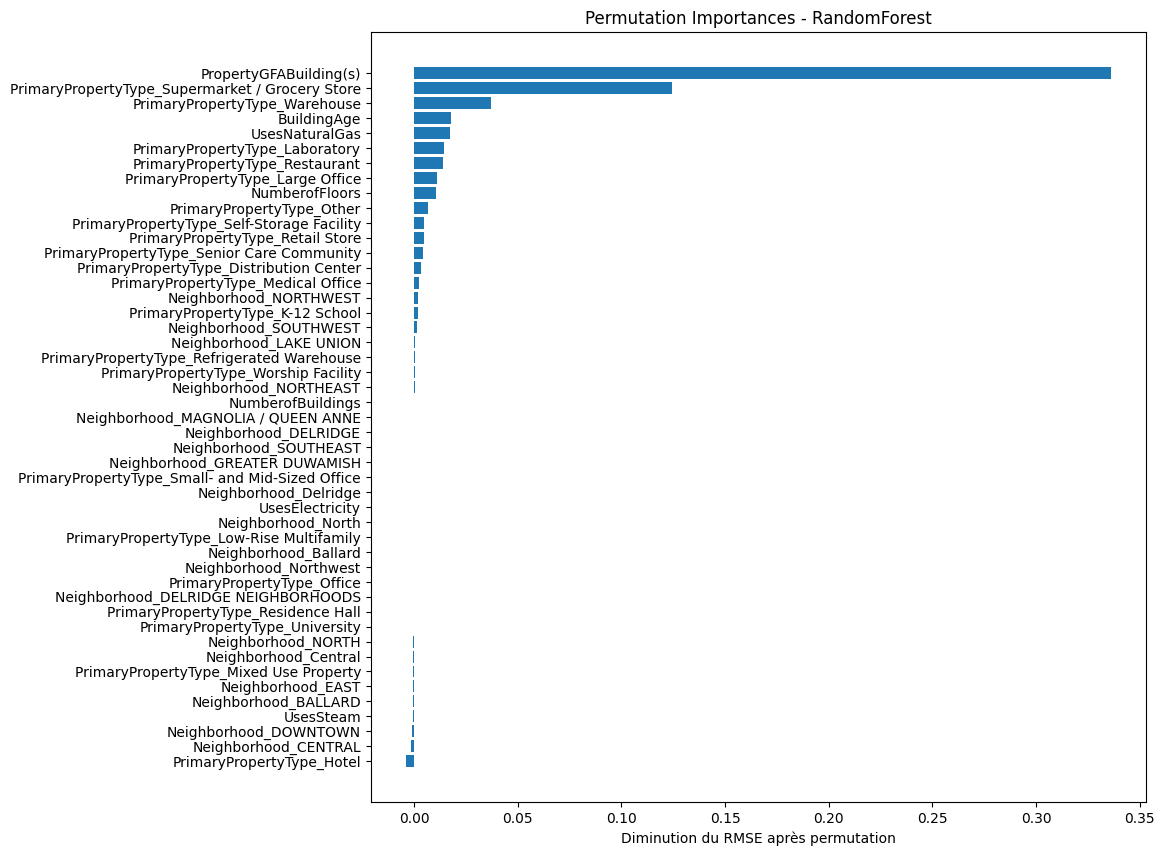

In [26]:
# Graphique 
plt.figure(figsize=(10,10))
plt.barh(perm_importances['feature'], perm_importances['importance_mean'])
plt.xlabel("Diminution du RMSE après permutation")
plt.title("Permutation Importances - RandomForest")
plt.show()

In [28]:
# Sauvegarde des features en list pour être passé à BentoMl
FEATURES = X_test.columns.tolist()

# Sauvegarde du model avec Bentoml

saved_model = bentoml.sklearn.save_model(
    name="energy_consumption_model",
    model=rf_best,
    metadata={
        "framework": "sklearn",
        "problem_type": "regression",
        "target": "SiteEnergyUseWN(kBtu)",
        "RMSE_cv": 1407516,
        "R2_cv": 0.82
    },
    custom_objects={
        "features": FEATURES
    }
)

print("Modèle sauvegardé sous le tag :", saved_model.tag)

Modèle sauvegardé sous le tag : energy_consumption_model:fa65vpw4cgn4oce5
